In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# === Grid Cell Positional Encoding (基于你给出的实现) ===
class GridCellPositionalEncoding(nn.Module):
    def __init__(self, dimension, qk_dim, num_heads):
        """
        Initialize the Grid Cell Positional Encoding.

        Parameters:
        - dimension: int, spatial dimensionality (e.g., 2 for 2D space)
        - qk_dim: int, the total embedding dimension (must be divisible by 2*(dimension+1))
        - num_heads: int, number of attention heads
        """
        super().__init__()
        self.dimension = dimension
        self.embedding_dim = qk_dim
        self.num_heads = num_heads
        self.num_head_dim = self.embedding_dim // num_heads

        assert self.num_head_dim % (2 * (self.dimension + 1)) == 0, "per num head embedding_dim must be divisible by 2*(dimension+1)"

        self.num_scales = self.num_head_dim // (2 * (dimension + 1))
        self.n = self.dimension + 1 if self.dimension > 1 else 1
        
        # 固定每个 head 的 omega
        omegas = []
        for _ in range(self.num_heads):
            omega = self._generate_simplex_vectors_with_projection(self.dimension)
            omegas.append(omega)
        # omegas 的形状: (num_heads, n+? , dimension) ——注意：此处生成的是 (dimension+1, d)
        self.register_buffer("omegas", torch.stack(omegas, dim=0))

    def _generate_simplex_vectors_with_projection(self, dimension, apply_random_rotation=True):
        """
        Generate n wave vectors (omega) in an n-dimensional space using a regular simplex projection.
        """
        if dimension == 1:
            return torch.tensor([[1.0]], dtype=torch.float32)  # 1D case

        points = torch.eye(dimension + 1, dtype=torch.float32)
        points = points - points.mean(dim=0)
        U, _, _ = torch.linalg.svd(points.T, full_matrices=False)
        reduced_vectors = U[:, :-1]
        reduced_vectors = reduced_vectors / torch.norm(reduced_vectors, dim=1, keepdim=True)
        if apply_random_rotation:
            Q, _ = torch.linalg.qr(torch.randn(dimension, dimension))
            reduced_vectors = reduced_vectors @ Q.T
        return reduced_vectors  # 形状: (dimension+1, dimension)

    def _generate_batch_encoding(self, positions):
        """
        Generate multi-scale positional encoding for batch input positions.

        Parameters:
        - positions: (batch_size, seq_length, d) tensor, input position vectors.

        Returns:
        - theta: (batch_size, num_heads, seq_length, n, num_scales) real-valued tensor.
        """
        theta_heads = []
        # 注意这里的缩放因子可根据需要调整，决定 theta 的幅度
        mag = 1 / (100 ** (2 * self.n * torch.arange(self.num_scales, dtype=torch.float32, device=positions.device)[:, None] / self.num_head_dim))
        # 对于每个 head
        for i in range(self.num_heads):
            omega = self.omegas[i]  # omega: (dimension+1, d)
            # 计算点积: positions shape (B, S, d)，omega shape (d+1, d) 注意：此处 d+1 其实就是 n，n = dimension+1
            theta = torch.einsum('bsd,nd->bsn', positions, omega)  # shape (B, S, n)
            theta = theta[:, :, :, None] * mag.T  # 变为 (B, S, n, num_scales)
            theta_heads.append(theta)
        theta_heads = torch.stack(theta_heads, dim=1)  # (B, num_heads, S, n, num_scales)
        return theta_heads

    def _compute_rotation_vectors(self, theta):
        """
        Convert angles theta to cosine and sine components.
        theta: (B, num_heads, S, n, S') tensor.
        Returns:
            cos_vec, sin_vec: each (B, num_heads, S, n, num_scales)
        """
        return torch.cos(theta), torch.sin(theta)

    def _apply_rotation(self, q, cos_vec, sin_vec):
        """
        Apply rotation transformation.

        q: (B, num_heads, seq_length, 2*n*num_scales) tensor.
        Expects the last dimension to be divisible as 2 * n * num_scales.
        """
        B, H, S, D = q.shape
        n, num_scales = cos_vec.shape[-2:]
        expected_D = 2 * n * num_scales
        assert D == expected_D, f"Expected last dim {D} == 2*n*num_scales = {expected_D}"
        # reshape q into pairs along last dim
        q = q.view(B, H, S, n, num_scales, 2)
        q_even = q[..., 0]  # (B, H, S, n, num_scales)
        q_odd  = q[..., 1]
        q_rotated_even = q_even * cos_vec - q_odd * sin_vec
        q_rotated_odd  = q_even * sin_vec + q_odd * cos_vec
        q_rot = torch.stack([q_rotated_even, q_rotated_odd], dim=-1)
        q_rot = q_rot.view(B, H, S, expected_D)
        return q_rot

    def forward(self, positions, q, k):
        """
        positions: (B, S, d) tensor.
        q, k: (B, num_heads, S, 2*n*num_scales) tensor.
        """
        theta = self._generate_batch_encoding(positions)  # (B, num_heads, S, n, num_scales)
        cos_vec, sin_vec = self._compute_rotation_vectors(theta)  # 各自形状相同
        q_rotated = self._apply_rotation(q, cos_vec, sin_vec)
        k_rotated = self._apply_rotation(k, cos_vec, sin_vec)
        return q_rotated, k_rotated

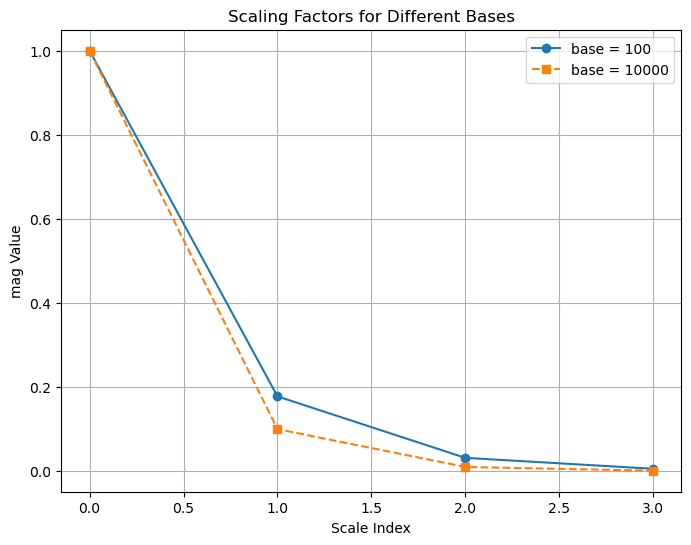

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Example parameters
dimension = 2
qk_dim = 24
num_heads = 1
num_head_dim = qk_dim // num_heads  # 24
n = dimension + 1 if dimension > 1 else 1  # 3
num_scales = num_head_dim // (2 * (dimension + 1))  # 24 / (2*3) = 4

# Compute scaling magnitudes (mag) based on different bases
# Use [:, None] to preserve shape for broadcasting, then squeeze to remove extra dims
base1 = 1000
mag1 = 1 / (base1 ** (2 * n * torch.arange(num_scales, dtype=torch.float32)[:, None] / num_head_dim))
mag1 = mag1.squeeze()  # Shape: (4,)

base2 = 10000
mag2 = 1 / (base2 ** (2 * n * torch.arange(num_scales, dtype=torch.float32)[:, None] / num_head_dim))
mag2 = mag2.squeeze()  # Shape: (4,)

# Convert to NumPy arrays for plotting
mag1_np = mag1.numpy()
mag2_np = mag2.numpy()
scales = np.arange(num_scales)

# Plot to compare mag values for the two bases
plt.figure(figsize=(8, 6))
plt.plot(scales, mag1_np, 'o-', label="base = 1000")
plt.plot(scales, mag2_np, 's--', label="base = 10000")
plt.xlabel("Scale Index")
plt.ylabel("Magnitude Value")
plt.title("Scaling Factors for Different Bases")
plt.legend()
plt.grid(True)
plt.show()